In [1]:
# !python -m spacy download en_core_web_lg
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_sm

# Introduction
The goal of this project is:
* Sort emails in these classes: Job description, Alert and Others.
* Classify jobs descriptions in jobs
* Rate cv and skills.

We will focus on the following:
* jobs: Data Scientist, Data Engineer,Big data developper and Data Analyst
* datasets: Glassdoors and job_emails1

# Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import os
import re
import nltk
from nltk import sent_tokenize 
from nltk.tokenize import word_tokenize,MWETokenizer 
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import spacy
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from nltk.chunk import conlltags2tree, tree2conlltags,ne_chunk
import joblib
# nltk.download('all')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Read and print the data

data from Assan

In [3]:
def read_data(data):
    """
    Read a csv file, drop the first colonne and return a dataframe
    input: csv file
    output:dataframe
    """
    df = pd.read_csv(data)
    df.drop(df.columns[[0]], axis=1, inplace=True)
    df.rename(columns={"label1":"label","label2":"job_title"},inplace=True)
    print( "this dataset is the concatenation of data from Assan, Kaggle and indeed (the source).")
    print("It has {} columns and {} rows".format(df.shape[1],df.shape[0]))
    print("the {} columns are {}".format(df.shape[1],df.columns.to_list()))
    return df

In [4]:
other_data=read_data('data/job_emails1.csv')
other_data.head()

this dataset is the concatenation of data from Assan, Kaggle and indeed (the source).
It has 4 columns and 421 rows
the 4 columns are ['Content', 'source', 'label', 'job_title']


,Content,source,label,job_title
0,"Ginko The company\n\nAt Ginko, we are Digital ...",indeed,job_opp,data_engineer
1,Nexity Company Description\n\n1st platform of ...,indeed,job_opp,data_engineer
2,"42c Who are we ?\nIn agile mode, we provide an...",indeed,job_opp,data_engineer
3,"RS2i Who are we ?\nAt RS2i, we are committed t...",indeed,job_opp,data_engineer
4,McKinsey & Company Who You'll Work With\nBased...,indeed,job_opp,data_engineer


data from glassdoor

In [5]:
def read_label_data(data,job_title,label):
    """
    Read a csv file add columns label and
    job_title
    input: data
    output: dataframe
    """
    df = pd.read_csv(data)
    df.drop(df.columns[[0]], axis=1, inplace=True)
    df.rename(columns={"Label":"source"},inplace=True)
    df['job_title']=job_title
    df['label']= label
    print("The dataset have {} columns and {} rows".format(df.shape[1],df.shape[0]))
    print("the {} columns are {}".format(df.shape[1],df.columns.to_list()))
    return df

In [6]:
data_scientist_job=read_label_data('data/glassdoor_data scientist.csv','Data Scientist','job_description')
data_scientist_job.head()

The dataset have 4 columns and 550 rows
the 4 columns are ['Content', 'source', 'job_title', 'label']


,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description


In [7]:
data_engineer_job=read_label_data('data/glassdoor_data engineer.csv','Data Engineer','job_description')
data_engineer_job.head()

The dataset have 4 columns and 346 rows
the 4 columns are ['Content', 'source', 'job_title', 'label']


,Content,source,job_title,label
0,Teknic\nData Engineer\nRemote\n\n Role: Data E...,glassdoor,Data Engineer,job_description
1,Expression Networks\n4.4\nData Engineer\nRemot...,glassdoor,Data Engineer,job_description
2,"TikTok\n3.7\n(HackerRank) Software Engineer, U...",glassdoor,Data Engineer,job_description
3,Denken Solution's Inc\nData Engineer\nCaliforn...,glassdoor,Data Engineer,job_description
4,Sedna Consulting Group\n4.1\nData Engineer\nRe...,glassdoor,Data Engineer,job_description


In [8]:
data_analyst_job=read_label_data('data/glassdoor_data analyst.csv','Data Analyst','job_description')
data_analyst_job.head()

The dataset have 4 columns and 550 rows
the 4 columns are ['Content', 'source', 'job_title', 'label']


,Content,source,job_title,label
0,WeLoveNoCode\n4.5\nData Analyst\nRemote\nEmplo...,glassdoor,Data Analyst,job_description
1,Associa\n4.0\nData & Reporting Analyst\nNewark...,glassdoor,Data Analyst,job_description
2,Net2Aspire\nJr. Data Analyst\nRemote\nEmployer...,glassdoor,Data Analyst,job_description
3,Siemens\n4.1\nData Analyst\nRemote\n\n Positio...,glassdoor,Data Analyst,job_description
4,Nava\nData Entry Analyst\nRemote\nEmployer Pro...,glassdoor,Data Analyst,job_description


In [9]:
Big_data_developer_job=read_label_data('data/glassdoor_Big data developer.csv','Big Data Developer','job_description')
Big_data_developer_job.head()

The dataset have 4 columns and 550 rows
the 4 columns are ['Content', 'source', 'job_title', 'label']


,Content,source,job_title,label
0,Datrageekz LLC\nBig Data Developer\nRemote\nEm...,glassdoor,Big Data Developer,job_description
1,ONE IT CORP\nBig Data Developer\nRemote\nEmplo...,glassdoor,Big Data Developer,job_description
2,Snappyhires\n4.7\nBig Data Developer\nRemote\n...,glassdoor,Big Data Developer,job_description
3,Momentum Recruitment\nBig Data Engineer\nRemot...,glassdoor,Big Data Developer,job_description
4,Brilliant Infotech\n3.8\nBig Data Developer\nR...,glassdoor,Big Data Developer,job_description


# Preprocessing

### Glassdoor data

In [10]:
print(data_scientist_job.isnull().sum(),
      data_engineer_job.isnull().sum(),
      data_analyst_job.isnull().sum(),
      Big_data_developer_job.isnull().sum())

Content      0
source       0
job_title    0
label        0
dtype: int64 Content      0
source       0
job_title    0
label        0
dtype: int64 Content      0
source       0
job_title    0
label        0
dtype: int64 Content      0
source       0
job_title    0
label        0
dtype: int64


In [11]:
[list(data_scientist_job['label'].unique()),
list(data_engineer_job['label'].unique()),
list( data_analyst_job['label'].unique()),
list(Big_data_developer_job['label'].unique())]

[['job_description'],
 ['job_description'],
 ['job_description'],
 ['job_description']]

In [12]:
Big_data_developer_job['job_title'].unique()

array(['Big Data Developer'], dtype=object)

We have only job description label in glassdoor data

### Assan, kaggle and indeed data

In [13]:
other_data['source'].value_counts()

kaggle    150
assan     140
indeed    131
Name: source, dtype: int64

In [14]:
other_data['source'].isnull().sum()

0

* Label data from Kaggle
    - we know that: data from kaggle are twits for sentiment analysis
    
 Thus:

In [15]:
mask = other_data['source']=='kaggle'
mask
other_data.loc[mask, 'label'] = 'other'
other_data.loc[mask, 'job_title'] = 'other'

In [16]:
print(other_data.loc[mask, 'job_title'].value_counts(dropna=False),"\n\n",
other_data.loc[mask, 'label'].value_counts(dropna=False))

other    150
Name: job_title, dtype: int64 

 other    150
Name: label, dtype: int64


In [17]:
other_data[other_data['source']=='kaggle'].head()

,Content,source,label,job_title
131,Message-ID: <18782981.1075855378110.JavaMail.e...,kaggle,other,other
132,Message-ID: <15464986.1075855378456.JavaMail.e...,kaggle,other,other
133,Message-ID: <24216240.1075855687451.JavaMail.e...,kaggle,other,other
134,Message-ID: <13505866.1075863688222.JavaMail.e...,kaggle,other,other
135,Message-ID: <30922949.1075863688243.JavaMail.e...,kaggle,other,other


* Label data from Indeed
    - we know that: data from indeed are data engineer's job description
 

In [18]:
mask1 = other_data['source']=='indeed'
mask1
other_data.loc[mask1, 'label'] = 'job_description'
other_data.loc[mask1, 'job_title'] = 'Data Engineer'

In [19]:
print(other_data.loc[mask1, 'job_title'].value_counts(dropna=False),"\n\n",
other_data.loc[mask1, 'label'].value_counts(dropna=False))

Data Engineer    131
Name: job_title, dtype: int64 

 job_description    131
Name: label, dtype: int64


In [20]:
other_data[other_data['source']=='indeed'].head()

,Content,source,label,job_title
0,"Ginko The company\n\nAt Ginko, we are Digital ...",indeed,job_description,Data Engineer
1,Nexity Company Description\n\n1st platform of ...,indeed,job_description,Data Engineer
2,"42c Who are we ?\nIn agile mode, we provide an...",indeed,job_description,Data Engineer
3,"RS2i Who are we ?\nAt RS2i, we are committed t...",indeed,job_description,Data Engineer
4,McKinsey & Company Who You'll Work With\nBased...,indeed,job_description,Data Engineer


* Label data from Assan 
    - All job_opp will become job_opportunity
    - all the other label will become other

In [21]:
mask_assan= other_data['source']=='assan'

In [22]:
other_data[mask_assan].isnull().sum()

Content       0
source        0
label         0
job_title    89
dtype: int64

In [23]:
other_data.loc[mask_assan]=other_data.loc[mask_assan].fillna("other")

In [24]:
other_data[mask_assan].isnull().sum()

Content      0
source       0
label        0
job_title    0
dtype: int64

In [25]:
other_data.loc[mask_assan,'job_title'].value_counts(dropna=False)

other                109
data_scientist        20
data_engineer          8
link                   2
Bigdata Developer      1
Name: job_title, dtype: int64

In [26]:
other_data.loc[mask_assan,'job_title']=other_data.loc[mask_assan,'job_title'].map({"data_scientist":"Data Scientist",
                                                                 "data_engineer":"Data Engineer",
                                                                "Bigdata Developer":"Big Data Developer",
                                                                "link":"other","other":"other"})

In [27]:
other_data.loc[mask_assan,'job_title'].value_counts(dropna=False)

other                 111
Data Scientist         20
Data Engineer           8
Big Data Developer      1
Name: job_title, dtype: int64

In [28]:
other_data.loc[mask_assan,'label'].value_counts(dropna=False)

job_opp    50
alert      47
other      34
missing     7
applied     1
link        1
Name: label, dtype: int64

In [29]:
def label_job_data(label):
    if label=='job_opp':
        return job_description
    else :
        return 'other'

In [30]:
other_data.loc[mask_assan,'label']=other_data.loc[mask_assan,'job_title'].apply(label_job_data)

In [31]:
# other_data['label'].unique()
other_data['label'].value_counts()

other              290
job_description    131
Name: label, dtype: int64

In [32]:
other_data['label'].isnull().sum()

0

### Concatanation of  all data

In [33]:
glassdoor_data_scientist_enginneer=pd.concat([data_scientist_job,data_engineer_job])
print(glassdoor_data_scientist_enginneer.isnull().sum(),glassdoor_data_scientist_enginneer['job_title'].unique())
glassdoor_data_scientist_enginneer

Content      0
source       0
job_title    0
label        0
dtype: int64 ['Data Scientist' 'Data Engineer']


,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description
...,...,...,...,...
341,"Accenture\n4.1\nData Engineer\nSan Francisco, ...",glassdoor,Data Engineer,job_description
342,Lincoln Financial\n3.6\nData Engineer (REMOTE)...,glassdoor,Data Engineer,job_description
343,Ultra Mobile\n4.4\nDigital Data Engineer I - R...,glassdoor,Data Engineer,job_description
344,"Antra, Inc\n4.5\nJr. Data Engineer\nSterling, ...",glassdoor,Data Engineer,job_description


In [34]:
glassdoor_data_scientist_enginneer_analyst=pd.concat([glassdoor_data_scientist_enginneer,data_analyst_job])
print(glassdoor_data_scientist_enginneer_analyst.isnull().sum(),glassdoor_data_scientist_enginneer_analyst['job_title'].unique())
glassdoor_data_scientist_enginneer_analyst

Content      0
source       0
job_title    0
label        0
dtype: int64 ['Data Scientist' 'Data Engineer' 'Data Analyst']


,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description
...,...,...,...,...
545,Softnice Inc.\n4.0\nJr. Business Analyst\nRemo...,glassdoor,Data Analyst,job_description
546,Disney Media & Entertainment Distribution\n3.9...,glassdoor,Data Analyst,job_description
547,PCS GLOBAL TECH\nJunior Data Analyst/ Entry Le...,glassdoor,Data Analyst,job_description
548,precision technology solutions\nRemote trainin...,glassdoor,Data Analyst,job_description


In [35]:
all_glassdoor_data =pd.concat([glassdoor_data_scientist_enginneer_analyst,Big_data_developer_job])
print(all_glassdoor_data.isnull().sum(),all_glassdoor_data['job_title'].unique())
all_glassdoor_data

Content      0
source       0
job_title    0
label        0
dtype: int64 ['Data Scientist' 'Data Engineer' 'Data Analyst' 'Big Data Developer']


,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description
...,...,...,...,...
545,Datrageekz LLC\nBig Data Developer\nRemote\nEm...,glassdoor,Big Data Developer,job_description
546,Aptivacorp\n4.4\nPython/Golang Developer (100%...,glassdoor,Big Data Developer,job_description
547,"Zscaler\n4.5\nData Engineer\nSan Jose, CA\n$93...",glassdoor,Big Data Developer,job_description
548,Pittsburgh Knights\nFront End Developer\nPitts...,glassdoor,Big Data Developer,job_description


In [36]:
all_datsaset = pd.concat([all_glassdoor_data,other_data])
print("null values: \n",all_datsaset.isnull().sum(),"\n\n","different jobs: \n",all_datsaset['job_title'].unique(),
      "\n\n","different label: \n",all_datsaset['label'].unique(),
     "\n\n","different source: \n",all_datsaset['source'].unique())
all_datsaset

null values: 
 Content      0
source       0
job_title    0
label        0
dtype: int64 

 different jobs: 
 ['Data Scientist' 'Data Engineer' 'Data Analyst' 'Big Data Developer'
 'other'] 

 different label: 
 ['job_description' 'other'] 

 different source: 
 ['glassdoor' 'indeed' 'kaggle' 'assan']


,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description
...,...,...,...,...
416,"Subject: Full stack Java Developer in Atlanta,...",assan,other,other
417,"8/24/22, 7:21 PM\n\nGmail - Last 100 Seats Rem...",assan,other,other
418,Subject: SENIOR DATA SCIENTIST opening at SHOP...,assan,other,other
419,Subject: Handshake Following Up | Assan SANOGO...,assan,other,other


In [37]:
all_datsaset.to_csv('data/alldata.csv',index=False)

In [82]:
# pd.read_csv('data/alldata.csv')

In [38]:
all_datsaset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2417 entries, 0 to 420
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Content    2417 non-null   object
 1   source     2417 non-null   object
 2   job_title  2417 non-null   object
 3   label      2417 non-null   object
dtypes: object(4)
memory usage: 94.4+ KB


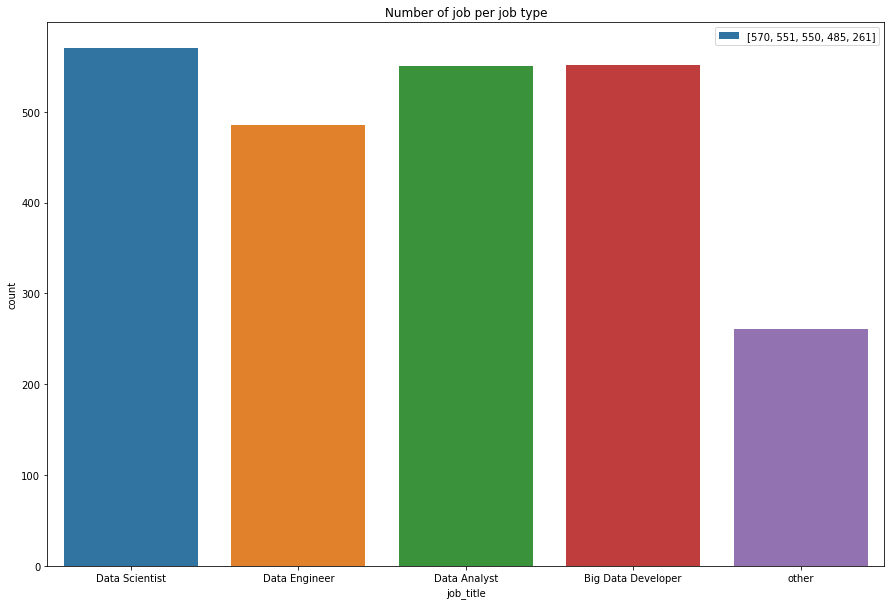

In [39]:
plt.figure(figsize=(15,10))
label = [i for i in all_datsaset['job_title'].value_counts().to_list()]
ax = sns.countplot(x="job_title",data=all_datsaset,label=label)
plt.title("Number of job per job type")
plt.legend()
plt.show()

In [40]:
emails = all_datsaset.copy()
emails.head()

,Content,source,job_title,label
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description


## Remove punctuation and stopwords

In [41]:
def remove_punct(text):
    """
    Remove punctuation from text
    input: text
    output: text
    """
    text_tok = word_tokenize(text)
    l=[]
    for word in text_tok:
        if not word in string.punctuation:
            l.append(word)
    resultat=" ".join(l)        
    return resultat

In [42]:
emails.Body_doc = emails.Content.apply(remove_punct)

<ipython-input-42-e35d8b89af52>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  emails.Body_doc = emails.Content.apply(remove_punct)


In [43]:
def remove_stopword(text):
    stop=set(stopwords.words('english'))
    text_tok = word_tokenize(text)
    l=[]
    for word in text_tok:
        if not word in stop:
            l.append(word)
    resultat=" ".join(l) 
    return resultat

In [44]:
emails.Body_doc = emails.Body_doc.apply(remove_stopword)

## Tokenization with NLTK Word Tokenize
* Tokenisation is the process of breaking up a given text into units called tokens. 
* Tokens can be individual words, phrases or even whole sentences.
* A MWETokenizer takes a string and merges multi-word expressions into single tokens, using a lexicon of MWEs.

In [45]:
def tokenizer(text):
    tokenizer = MWETokenizer([('Machine', 'Learning'), ('Data','Scientist'),('Data','Engineer'),('Data','Analyst'),
                              ('Cloud','Computing'),('Artificial','Intelligence'),('Business','Managers'),
                             ('Big', 'Data'),('Big', 'Data','Developer'),('Data','Driven'),('Big','Query'),('data','lake'),
                             ('data','sources'),('job','description')],separator=' ')
    for t in sent_tokenize(text):
        x=tokenizer.tokenize(t.split())
    return(x)

In [46]:
emails.Body_doc = emails.Body_doc.apply(tokenizer)

## Lemmatization
Lemmatization is the process where we take individual tokens from a sentence and we try to reduce them to their base form. 

In [47]:
lemmatizer=WordNetLemmatizer()

In [48]:
def lemm(text):
#     text_tok = word_tokenize(text)
    l=[]
    for word in text:
        l.append(lemmatizer.lemmatize(word))
    resultat=" ".join(l) 
    return resultat

In [49]:
emails.Body_doc = emails.Body_doc.apply(lemm)

In [50]:
emails.Body_doc

0      Infoserv LLC Data Scientist Remote Employer Pr...
1      ExxonMobil 3.1 Data Scientist Clinton NJ 94K 1...
2      eBay Inc. 4.1 Data Scientist/Applied Researche...
3      TikTok 3.7 Data Scientist University Graduate ...
4      Mastercard 4.3 Data Scientist AI Services Mast...
                             ...                        
416    Subject Full stack Java Developer Atlanta GA| ...
417    8/24/22 7:21 PM Gmail Last 100 Seats Remaining...
418    Engineer Data Analyst similar role Relevant ba...
419    Subject Handshake Following Up Assan SANOGO Fr...
420    Subject Fulltime Data Engineer || Dallas TX Re...
Name: Content, Length: 2417, dtype: object

In [51]:
def sep(text):
    r=text.replace('/',' ') 
    return r

In [52]:
emails.Body_doc = emails.Body_doc.apply(sep)

In [53]:
emails.Body_doc

0      Infoserv LLC Data Scientist Remote Employer Pr...
1      ExxonMobil 3.1 Data Scientist Clinton NJ 94K 1...
2      eBay Inc. 4.1 Data Scientist Applied Researche...
3      TikTok 3.7 Data Scientist University Graduate ...
4      Mastercard 4.3 Data Scientist AI Services Mast...
                             ...                        
416    Subject Full stack Java Developer Atlanta GA| ...
417    8 24 22 7:21 PM Gmail Last 100 Seats Remaining...
418    Engineer Data Analyst similar role Relevant ba...
419    Subject Handshake Following Up Assan SANOGO Fr...
420    Subject Fulltime Data Engineer || Dallas TX Re...
Name: Content, Length: 2417, dtype: object

### SpaCy Tokenizer
With spacy tokenization we don't have to remove punctuation or any other cleannings. It handle all the stuff

In [54]:
nlp=spacy.load('en_core_web_sm')

In [55]:
def nlp_spacy(text): 
    return nlp(text)


In [56]:
emails['Body_doc1']=emails.Content.apply(nlp_spacy)

In [57]:
emails.Body_doc1[0]

0    (Infoserv, LLC, \n, Data, Scientist, \n, Remot...
0    (Teknic, \n, Data, Engineer, \n, Remote, \n\n ...
0    (WeLoveNoCode, \n, 4.5, \n, Data, Analyst, \n,...
0    (Datrageekz, LLC, \n, Big, Data, Developer, \n...
0    (Ginko, The, company, \n\n, At, Ginko, ,, we, ...
Name: Body_doc1, dtype: object

In [58]:
# emails['Body_doc1']

In [59]:
def no_ent(doc):
    r= []
    ents = [e.text for e in doc.ents]
    for item in doc:
        if item.text in ents:
            pass
        else:
            r.append(item.text)
    return(" ".join(r))


In [60]:
emails.Body_doc1=emails.Body_doc1.apply(no_ent)

In [61]:
print(emails.Body_doc1[0])

0    Infoserv LLC \n Data Scientist \n Remote \n Em...
0    Teknic \n Data Engineer \n Remote \n\n  Role :...
0    WeLoveNoCode \n \n Data Analyst \n Remote \n E...
0    Datrageekz LLC \n Big Data Developer \n Remote...
0    The company \n\n At , we are specialists , and...
Name: Body_doc1, dtype: object


In [62]:
emails.tail()

,Content,source,job_title,label,Body_doc1
416,"Subject: Full stack Java Developer in Atlanta,...",assan,other,other,"Subject : Full stack Java Developer in , GA| F..."
417,"8/24/22, 7:21 PM\n\nGmail - Last 100 Seats Rem...",assan,other,other,", 7:21 PM \n\n Gmail - Last Seats Remaining In..."
418,Subject: SENIOR DATA SCIENTIST opening at SHOP...,assan,other,other,Subject : SENIOR DATA SCIENTIST opening at SHO...
419,Subject: Handshake Following Up | Assan SANOGO...,assan,other,other,Subject : Handshake Following Up | Assan SANOG...
420,"Subject: Fulltime Data Engineer || Dallas, TX ...",assan,Data Engineer,other,"Subject : Fulltime Data Engineer || , ( Remote..."


# Modelisation

In [63]:
corpus=list(emails['Body_doc1'])
len(corpus)

2417

### vectorize

In [64]:
job_description = emails[emails['label']=='job_description']
job_description

,Content,source,job_title,label,Body_doc1
0,Infoserv LLC\nData Scientist\nRemote\nEmployer...,glassdoor,Data Scientist,job_description,Infoserv LLC \n Data Scientist \n Remote \n Em...
1,"ExxonMobil\n3.1\nData Scientist\nClinton, NJ\n...",glassdoor,Data Scientist,job_description,"\n \n Data Scientist \n , NJ \n $ 94 K - $ 144..."
2,eBay Inc.\n4.1\nData Scientist/Applied Researc...,glassdoor,Data Scientist,job_description,Inc. \n \n Data Scientist / Applied Researcher...
3,"TikTok\n3.7\nData Scientist, University Gradua...",glassdoor,Data Scientist,job_description,"\n \n Data Scientist , University Graduate - S..."
4,"Mastercard\n4.3\nData Scientist, AI Services -...",glassdoor,Data Scientist,job_description,"\n \n Data Scientist , Services - Launch 2023 ..."
...,...,...,...,...,...
126,TOTAL DIGITAL FACTORY In accordance with the c...,indeed,Data Engineer,job_description,TOTAL FACTORY In accordance with the company '...
127,"RH HUMANISTE RH HUMANISTE, Recruitment Consult...",indeed,Data Engineer,job_description,"RH HUMANISTE RH HUMANISTE , Recruitment Consul..."
128,Crédit Agricole CIB Job Description\nAre you l...,indeed,Data Engineer,job_description,Crédit Agricole CIB Job Description \n Are you...
129,Autres Filiales Description of the offer\nData...,indeed,Data Engineer,job_description,"Autres Filiales Description of the offer \n , ..."


In [65]:
job_description['job_title'].unique()

array(['Data Scientist', 'Data Engineer', 'Data Analyst',
       'Big Data Developer'], dtype=object)

In [66]:
X_Data = job_description["Body_doc1"]
Y_Data = job_description["job_title"]

cv = CountVectorizer()
X_Data = cv.fit_transform(X_Data)

### Train test split

In [67]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X_Data, Y_Data,test_size=0.3,random_state=101)

### Model fitting

In [68]:
# from sklearn.externals import joblib
# import sklearn.external.joblib as extjoblib
import joblib

In [69]:
model = tree.DecisionTreeClassifier()
model.fit(X_Train,Y_Train)

DecisionTreeClassifier()

### Prediction

In [70]:
predicted = model.predict(X_Test)
print(classification_report(Y_Test, predicted))

                    precision    recall  f1-score   support

Big Data Developer       0.94      0.99      0.97       156
      Data Analyst       0.99      0.99      0.99       181
     Data Engineer       0.97      0.94      0.95       140
    Data Scientist       0.99      0.98      0.98       162

          accuracy                           0.97       639
         macro avg       0.97      0.97      0.97       639
      weighted avg       0.98      0.97      0.97       639



In [71]:
model.score(X_Train,Y_Train)

0.9919354838709677

In [72]:
model.score(X_Test,Y_Test)

0.974960876369327

In [73]:
pd.Series(predicted)

0      Big Data Developer
1          Data Scientist
2      Big Data Developer
3           Data Engineer
4            Data Analyst
              ...        
634    Big Data Developer
635    Big Data Developer
636          Data Analyst
637        Data Scientist
638          Data Analyst
Length: 639, dtype: object

In [74]:
results = Y_Test.copy()
results.reset_index(drop=True, inplace=True)
# results['predicted'] =pd.Series(predicted)
results = results.to_list()
predicted =pd.Series(predicted).to_list()

In [75]:
joblib.dump(model, 'model.joblib')

['model.joblib']

In [76]:
datares = pd.DataFrame(zip(predicted,results),columns=["predicted","test"])
datares

,predicted,test
0,Big Data Developer,Big Data Developer
1,Data Scientist,Data Scientist
2,Big Data Developer,Big Data Developer
3,Data Engineer,Data Engineer
4,Data Analyst,Data Analyst
...,...,...
634,Big Data Developer,Big Data Developer
635,Big Data Developer,Big Data Developer
636,Data Analyst,Data Analyst
637,Data Scientist,Data Scientist


https://github.com/bellabie/spacy-tf-idf/blob/master/tf-idf.py

https://www.kaggle.com/code/sanabdriss/nlp-extract-skills-from-job-descriptions/notebook    
https://medium.com/@Olohireme/job-skills-extraction-from-data-science-job-posts-38fd58b94675   


In [77]:
# !pip install dtreeviz
# from dtreeviz.trees import dtreeviz


In [78]:
# lab = cv.fit_transform(Y_Train)
# lab

In [79]:
# vis = dtreeviz(model,X_Train,lab,target_name='job_type')